### Full - Baseline : GRU

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import random

import sys
from datetime import datetime

In [3]:
# check GPU situation
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)

True
1
0
NVIDIA GeForce RTX 3090 Ti
11.8


In [4]:
# function to seed random seed
def setup_seed(seed):
     random.seed(seed)
     np.random.seed(seed)
     if torch.cuda.is_available():
          torch.cuda.manual_seed_all(seed)

     torch.manual_seed(seed)
     torch.cuda.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)

     torch.backends.cudnn.deterministic = True
     torch.backends.cudnn.benchmark = False

In [5]:
# load the raw data
def get_data(dataset):
    data = pd.read_csv(f'./data/{dataset}_MRR.csv')
    mrr_data = data['MRR']
    mrr_train = mrr_data[:int(len(mrr_data) * 0.7)]
    mrr_test = mrr_data[int(len(mrr_data) * 0.7):] 

    return mrr_train, mrr_test

In [6]:
# transfer raw data to dataset class
class myDataset(Dataset):
    def __init__(self, data, past_wafer, future_step):
        data = torch.tensor(data.values)
        seqs = []
        tars = []
        future_step = future_step - 1
        for i in range(past_wafer, len(data) - future_step):
            seq = data[i - past_wafer:i]
            tar = data[i + future_step]
            seqs.append(seq)
            tars.append(tar)
        
        self.x = torch.unsqueeze(torch.stack(seqs), 2).contiguous()
        self.y = torch.stack(tars).contiguous()
        self.len = len(seqs)

    def __getitem__(self, idx):

        x = self.x[idx].double()
        y = self.y[idx].double()

        return x, y
    
    def __len__(self):
        return self.len

In [7]:
# GRU model setting
class GRUmodel(nn.Module):
    def __init__(self, input_dim, inter_dim, layer_num):
        super(GRUmodel, self).__init__()
        self.inter_dim = inter_dim
        self.layer_num = layer_num

        # define GRU layer
        self.gru = nn.GRU(input_dim, inter_dim, layer_num, batch_first=True)

        # define MLP layer
        self.mlp = nn.Sequential(
            nn.Linear(inter_dim, 1),
            nn.ReLU())
        

    def forward(self, x):
        # initialize original memory
        h0 = torch.zeros(self.layer_num, x.size(0), self.inter_dim).double().to(x.device)

        # forward propagation，x size (batch_size, sequence_length, input_dim)
        out, _ = self.gru(x, h0)

        # retain the last memory
        out = self.mlp(out[:, -1, :])

        return out.squeeze(1)


In [8]:
# split train_dataloader and val_dataloader from train_dataset
def get_loaders(train_dataset, seed, batch_size, val_ratio=0.1):
    dataset_len = int(len(train_dataset))
    train_use_len = int(dataset_len * (1 - val_ratio))
    val_use_len = int(dataset_len * val_ratio)
    val_start_index = random.randrange(train_use_len)
    indices = torch.arange(dataset_len)

    train_sub_indices = torch.cat([indices[:val_start_index], indices[val_start_index+val_use_len:]])
    train_subset = Subset(train_dataset, train_sub_indices)

    val_sub_indices = indices[val_start_index:val_start_index+val_use_len]
    val_subset = Subset(train_dataset, val_sub_indices)

    train_dataloader = DataLoader(train_subset, batch_size,
                            shuffle=False)

    val_dataloader = DataLoader(val_subset, batch_size,
                            shuffle=False)

    return train_dataloader, val_dataloader

In [9]:
def test(model, test_dataloader, device):
    model.eval()

    test_pred_list = []
    test_ground_list = []
    loss_list = []

    for x, y in test_dataloader:
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():

            model = model.double()
            out = model(x).to(device)
            loss = F.mse_loss(out, y, reduction='mean')
            
            test_pred_list.extend(out.detach().cpu().tolist())
            test_ground_list.extend(y.detach().cpu().tolist())
            
        loss_list.append(loss.detach().cpu().item())
    
    avg_loss = sum(loss_list)/len(loss_list)

    return avg_loss, [test_pred_list, test_ground_list] 

In [33]:
def train(model, train_dataloader, val_dataloader, optimizer, epoch, device,
          path):
    min_loss = 1e+8
    early_stop_win = 50

    for i_epoch in range(epoch):

        loss_list = []
        acu_loss = 0
        model.train()

        for x, y in train_dataloader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            model = model.double()
            out = model(x).to(device)
            loss = F.mse_loss(out, y, reduction='mean')

            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())
            acu_loss += loss.item()

        val_loss = 0

        # early stopping by validation
        if val_dataloader is not None:

            val_loss, val_result = test(model, val_dataloader, 'cuda')

            if val_loss < min_loss:
                torch.save(model.state_dict(), path)

                min_loss = val_loss
                stop_improve_count = 0
            else:
                stop_improve_count += 1

            if stop_improve_count >= early_stop_win:
                break

        else:
            if acu_loss < min_loss:
                torch.save(model.state_dict(), path)
                min_loss = acu_loss

        # print each epoch
        print(
            'epoch ({} / {}) (Train_loss:{:.8f}, ACU_loss:{:.8f}, Val_loss:{:.8f})'
            .format(
                i_epoch + 1,
                epoch,
                acu_loss / len(train_dataloader),
                acu_loss,
                val_loss,
            ),
            flush=True)

A456

In [ ]:
# training setting
dataset = 'A456'
batch_size = 8
input_dim = 1
inter_dim = 64
layer_num = 1
past_wafer = 4
future_step = 1
val_ratio = 0.2
seed = 2

# set random seed
setup_seed(seed)

In [49]:
# get training and testing dataset
train_orig, test_orig = get_data(dataset)
# concat the first n wafer data from training set
test_extend = pd.concat((train_orig[-past_wafer:], test_orig))

train_dataset = myDataset(train_orig, past_wafer, future_step)
test_dataset = myDataset(test_extend, past_wafer, future_step)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

# split training and validation dataset
train_dataloader, val_dataloader = get_loaders(train_dataset, seed, batch_size, val_ratio)

# establish the model
model = GRUmodel(input_dim, inter_dim, layer_num).to('cuda')
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

# save path of the best model
now = datetime.now()
datestr = now.strftime('%m_%d-%H_%M_%S')
save_path = f'./save_path/{datestr}.pt'

# start training
train(model, train_dataloader, val_dataloader, optimizer, 2000, 'cuda', save_path)

epoch (1 / 2000) (Train_loss:4575.92344082, ACU_loss:306586.87053462, Val_loss:4956.34283972)
epoch (2 / 2000) (Train_loss:3872.63096191, ACU_loss:259466.27444805, Val_loss:4325.02954472)
epoch (3 / 2000) (Train_loss:3317.21160678, ACU_loss:222253.17765430, Val_loss:3735.89782530)
epoch (4 / 2000) (Train_loss:2814.84026432, ACU_loss:188594.29770929, Val_loss:3211.14417000)
epoch (5 / 2000) (Train_loss:2395.40818135, ACU_loss:160492.34815046, Val_loss:2777.78243099)
epoch (6 / 2000) (Train_loss:2024.19352539, ACU_loss:135620.96620104, Val_loss:2380.30702185)
epoch (7 / 2000) (Train_loss:1705.83286428, ACU_loss:114290.80190709, Val_loss:2043.70417990)
epoch (8 / 2000) (Train_loss:1433.89981020, ACU_loss:96071.28728340, Val_loss:1751.03025999)
epoch (9 / 2000) (Train_loss:1200.13485511, ACU_loss:80409.03529260, Val_loss:1496.13532222)
epoch (10 / 2000) (Train_loss:999.57337836, ACU_loss:66971.41635034, Val_loss:1274.57641364)
epoch (11 / 2000) (Train_loss:828.27547610, ACU_loss:55494.4568

MSE :  10.803


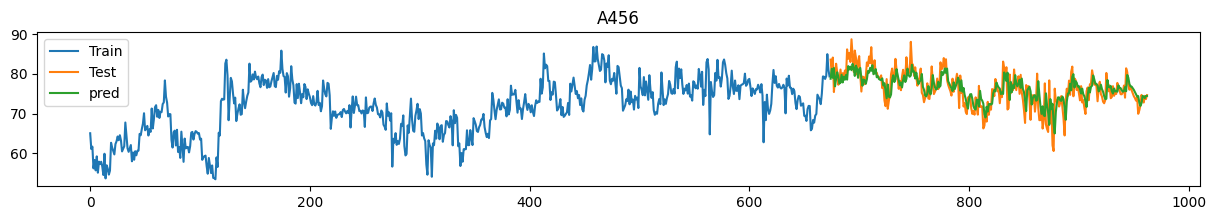

In [50]:
# load the best model for testing
model.load_state_dict(torch.load(save_path))
best_model = model.to('cuda')
avg_loss, test_list = test(best_model, test_dataloader, 'cuda')
print('MSE : ', round(avg_loss, 3))

# plot the result
y_train = train_orig
y_pred = test_list[0]
y_truth = test_list[1]

plt.figure(figsize=(15, 2), dpi=100)
plt.plot(range(y_train.shape[0]), y_train, label='Train')
plt.plot(range(y_train.shape[0], y_train.shape[0] + len(y_truth)), y_truth, label='Test')
plt.plot(range(y_train.shape[0], y_train.shape[0] + len(y_truth)), y_pred, label='pred')
plt.title(dataset)
plt.legend(loc='upper left')
plt.show()

B456

In [13]:
# training setting
dataset = 'B456'
batch_size = 8
input_dim = 1
inter_dim = 64
layer_num = 1
past_wafer = 4
future_step = 1
val_ratio = 0.3
seed = 2

# set random seed
setup_seed(seed)

In [14]:
# get training and testing dataset
train_orig, test_orig = get_data(dataset)
# concat the first n wafer data from training set
test_extend = pd.concat((train_orig[-past_wafer:], test_orig))

train_dataset = myDataset(train_orig, past_wafer, future_step)
test_dataset = myDataset(test_extend, past_wafer, future_step)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

# split training and validation dataset
train_dataloader, val_dataloader = get_loaders(train_dataset, seed, batch_size, val_ratio)

# establish the model
model = GRUmodel(input_dim, inter_dim, layer_num).to('cuda')
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

# save path of the best model
now = datetime.now()
datestr = now.strftime('%m_%d-%H_%M_%S')
save_path = f'./save_path/{datestr}.pt'

# start training
train(model, train_dataloader, val_dataloader, optimizer, 2000, 'cuda', save_path)

epoch (1 / 2000) (Train_loss:5215.87503961, ACU_loss:318168.37741635, Val_loss:6068.32201577)
epoch (2 / 2000) (Train_loss:4521.16596910, ACU_loss:275791.12411502, Val_loss:5415.07552601)
epoch (3 / 2000) (Train_loss:3988.99431216, ACU_loss:243328.65304172, Val_loss:4829.79025820)
epoch (4 / 2000) (Train_loss:3472.21274825, ACU_loss:211804.97764305, Val_loss:4243.76193841)
epoch (5 / 2000) (Train_loss:3004.26382941, ACU_loss:183260.09359395, Val_loss:3756.20150222)
epoch (6 / 2000) (Train_loss:2614.35081894, ACU_loss:159475.39995550, Val_loss:3330.98132926)
epoch (7 / 2000) (Train_loss:2273.70692089, ACU_loss:138696.12217407, Val_loss:2952.59096528)
epoch (8 / 2000) (Train_loss:1973.03408142, ACU_loss:120355.07896675, Val_loss:2614.08178081)
epoch (9 / 2000) (Train_loss:1707.14736086, ACU_loss:104135.98901230, Val_loss:2310.93856922)
epoch (10 / 2000) (Train_loss:1472.28973682, ACU_loss:89809.67394605, Val_loss:2039.68673909)
epoch (11 / 2000) (Train_loss:1265.38920813, ACU_loss:77188.

MSE :  15.383


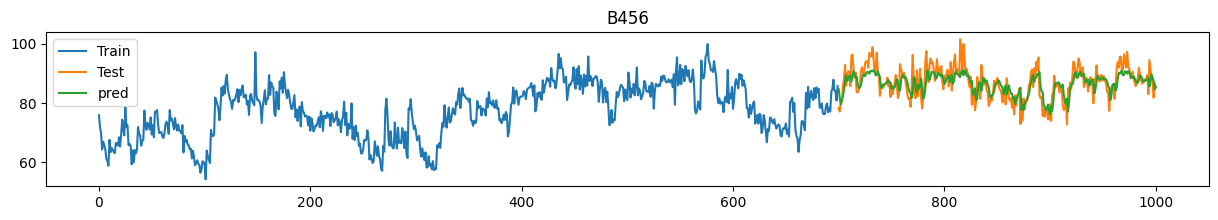

In [16]:
# load the best model for testing
model.load_state_dict(torch.load(save_path))
best_model = model.to('cuda')
avg_loss, test_list = test(best_model, test_dataloader, 'cuda')
print('MSE : ', round(avg_loss, 3))

# plot the result
y_train = train_orig
y_pred = test_list[0]
y_truth = test_list[1]

plt.figure(figsize=(15, 2), dpi=100)
plt.plot(range(y_train.shape[0]), y_train, label='Train')
plt.plot(range(y_train.shape[0], y_train.shape[0] + len(y_truth)), y_truth, label='Test')
plt.plot(range(y_train.shape[0], y_train.shape[0] + len(y_truth)), y_pred, label='pred')
plt.title(dataset)
plt.legend(loc='upper left')
plt.show()